# Validation/Verification & Performance comparison for LOGIC gates with multiple hidden layers and multiple neurons

For Google Colab or Kaggle install crysx_nn

In [ ]:
! pip install --upgrade https://github.com/manassharma07/crysx_nn/tarball/main

## Import stuff

In [1]:
import numpy as np
print('numpy',np.__version__)

import matplotlib.pyplot as plt


# Import loss functions
from crysx_nn.loss import MSE_loss, MSE_loss_grad
from crysx_nn.loss import BCE_loss, BCE_loss_grad
# Import activation functions
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import ReLU, ReLU_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import Tanh_offset, Tanh_offset
# Import neural network functions
from crysx_nn.network import back_propagation, back_propagation_fast
from crysx_nn.network import nn_optimize, nn_optimize_fast
from crysx_nn.network import forward_feed
from crysx_nn.network import visualize


from tqdm.notebook import tqdm


# import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
print('tf',tf.__version__)

import torch, torchvision
print('torch',torch.__version__)
rng = np.random.default_rng()
import time
from timeit import default_timer as timer

numpy 1.19.2


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\crysx_nn\network.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


tf 2.2.3
torch 1.10.1


## Ensure that evertyhing is only using CPU

In [2]:
torch.cuda.is_available()

False

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
print(tf.test.is_built_with_cuda())

True


## Check if NumPy is linked with MKL or not

In [6]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Start with the common stuff

In [222]:
nInputs = 2 # No. of features
nOutputs = 1
neurons_per_layer = [10,10,10,1] # Hidden layers and output layer
activation_func_names = ['Sigmoid','Sigmoid','Sigmoid','Sigmoid',]
nLayers = len(neurons_per_layer)
eeta = 0.5
nEpochs=10**4
batchSize = 4

#### Activation function dictionary for all the frameworks

In [223]:


act_func_dict_PyTorch = {'Sigmoid':torch.nn.Sigmoid(),'ReLU':torch.nn.ReLU(),'ELU':torch.nn.ELU(), 'Hardshrink' : torch.nn.Hardshrink(),'Hardsigmoid':torch.nn.Hardsigmoid(),\
                 'Hardtanh':torch.nn.Hardtanh(),'Hardswish':torch.nn.Hardswish(),'LeakyReLU':torch.nn.LeakyReLU(),'LogSigmoid':torch.nn.LogSigmoid(),\
                 'Tanh':torch.nn.Tanh(),'Softmax':torch.nn.Softmax(dim=1),'Softmin':torch.nn.Softmin(dim=1),'LogSoftmax':torch.nn.LogSoftmax()}
act_func_dict_tensorflow = {'Sigmoid':'sigmoid','Softmax':'softmax','ReLU':'relu','LeakyReLU':'leakyrelu'}



## Visualize 

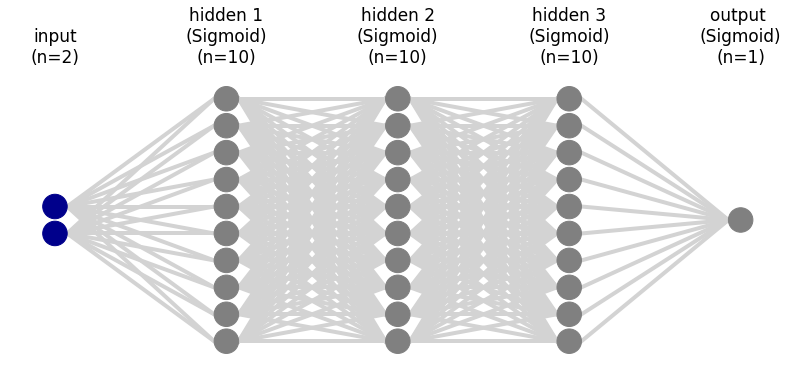

In [224]:
visualize(nInputs, neurons_per_layer, activation_func_names)

## Set inputs

In [225]:
inputs = np.array([[0.,0.,1.,1.],[0.,1.,0.,1.]]).T.astype('float32')
print(inputs)
print(inputs.dtype)


[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
float32


In [226]:
# AND function
outputAND = np.array([0.,0.,0.,1.])
outputAND = np.asarray([outputAND]).T
# OR function
outputOR = np.array([0.,1.,1.,1.])
outputOR = np.asarray([outputOR]).T
# NAND function
outputNAND = np.array([1.,1.,1.,0.])
outputNAND = np.asarray([outputNAND]).T
# XOR function
outputXOR = np.array([0.,1.,1.,0.])
outputXOR = np.asarray([outputXOR]).T

## Set outputs

In [227]:
# outputs = outputAND
# outputs = outputOR
# outputs = outputNAND
outputs = outputXOR
outputs = outputs.astype('float32')
print(outputs)
print(outputs.dtype)

[[0.]
 [1.]
 [1.]
 [0.]]
float32


# Keras implementation

In the following we have to be careful and change the network nodes, and layers manually. 

TODO: Make the neural network be generated in a loop automatically using the parameters already defined.

In [228]:
# # define the keras model
# model = Sequential()
# model.add(Dense(100, input_dim=2, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(1, activation='sigmoid', use_bias=True))

# model.summary()

## Make the neural network programatically

In [229]:
# define the keras model
model = Sequential()
# First Hidden layer
model.add(Dense(neurons_per_layer[0], input_dim=nInputs, activation=act_func_dict_tensorflow[activation_func_names[0]], use_bias=True))

if nLayers>1:
    # Hidden layers
    for i in range(nLayers-2):
        model.add(Dense(neurons_per_layer[i], activation=act_func_dict_tensorflow[activation_func_names[i]], use_bias=True))
    # Output layer
    model.add(Dense(neurons_per_layer[nLayers-1], activation=act_func_dict_tensorflow[activation_func_names[nLayers-1]], use_bias=True))
    
model.summary()
    

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_21 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


## Check the initial weights and biases for each layer

Note how the weights matrix is not 4x2 but rather 2x4

In [230]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.66594917  0.3255703   0.4217617  -0.5748579   0.28142577 -0.6079688
   0.07288826  0.41467816  0.6484485  -0.31692356]
 [-0.2963193   0.14479566 -0.55136573  0.6141735   0.23411208 -0.14096516
  -0.3917219   0.28841275  0.18055034 -0.49972472]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 Weights for layer  2
[[ 0.00994706  0.05536598 -0.36000982  0.09519029 -0.14681819  0.40174198
  -0.36096585  0.45297408  0.33489203  0.31534612]
 [-0.40326124  0.45254755  0.20782936  0.16808486 -0.5108596   0.49479425
   0.46236777 -0.3556854  -0.06335884 -0.4771186 ]
 [ 0.13486147 -0.5050279  -0.4795089   0.50442934 -0.25621635  0.11421394
   0.4717815  -0.33516496  0.50843763 -0.02064139]
 [ 0.5366782   0.20392096 -0.39171576 -0.24347037 -0.30675584 -0.12333089
  -0.54454815 -0.3736131  -0.01887    -0.22184446]
 [-0.5383263  -0.00377947  0.40535975  0.2945248  -0.5048766  -0.39515907
   0.34001458  0.19481814  0.5016345  -0.3373332 ]
 [-0.24846274 -0.0922237 

## Save the weights generated by tf.keras and use them for our implementation as well

In [231]:
weightsOriginal = []
biasesOriginal = []


for i in range(nLayers):
    weightsOriginal.append(model.layers[i].get_weights()[0].T)
    biasesOriginal.append(model.layers[i].get_weights()[1].T)

print('Weights matrices: ',weightsOriginal)
print('Biases: ',biasesOriginal)

Weights matrices:  [array([[ 0.66594917, -0.2963193 ],
       [ 0.3255703 ,  0.14479566],
       [ 0.4217617 , -0.55136573],
       [-0.5748579 ,  0.6141735 ],
       [ 0.28142577,  0.23411208],
       [-0.6079688 , -0.14096516],
       [ 0.07288826, -0.3917219 ],
       [ 0.41467816,  0.28841275],
       [ 0.6484485 ,  0.18055034],
       [-0.31692356, -0.49972472]], dtype=float32), array([[ 0.00994706, -0.40326124,  0.13486147,  0.5366782 , -0.5383263 ,
        -0.24846274,  0.42331684, -0.3503977 ,  0.07045221, -0.27435556],
       [ 0.05536598,  0.45254755, -0.5050279 ,  0.20392096, -0.00377947,
        -0.0922237 ,  0.54570615,  0.1176275 , -0.27075735,  0.00960732],
       [-0.36000982,  0.20782936, -0.4795089 , -0.39171576,  0.40535975,
         0.3631835 , -0.12306085,  0.28087538,  0.30211174,  0.09231043],
       [ 0.09519029,  0.16808486,  0.50442934, -0.24347037,  0.2945248 ,
         0.07374734, -0.44909683, -0.46646088,  0.05298823, -0.34200537],
       [-0.14681819, -0.5

## Compile model

In [232]:
# compile the keras model

# In the following manner we can't set the learning rate of the optimizer
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# So use the following instead
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['mse'])



## Forward feed

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [21]:
model.evaluate(inputs, outputs, batch_size=batchSize)

1/1 [==============================] - 0s 989us/step - loss: 0.2568 - mse: 0.2568


[0.2567862272262573, 0.2567862272262573]

## Does tf.model.evaluate change the weights and biases?

In [22]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.04027619  0.00556656 -0.01427691 ... -0.02504678 -0.01056639
   0.0320145 ]
 [-0.03984804 -0.04732465  0.02517711 ... -0.05462958  0.02752879
   0.05121659]]

 Biases for layer  1
[0. 0. 0. ... 0. 0. 0.]

 Weights for layer  2
[[ 0.03019984 -0.02509424  0.03596538 ...  0.03193791  0.02858563
  -0.02176725]
 [-0.0048652  -0.0093021  -0.03664855 ... -0.03543811  0.03227868
   0.03211344]
 [ 0.00300057  0.03435935  0.0360274  ... -0.03110942  0.02810709
  -0.00253981]
 ...
 [-0.00575778  0.00702398 -0.03209672 ... -0.02738092  0.03347227
   0.00419825]
 [ 0.00110932 -0.02100432 -0.03820309 ... -0.02372533 -0.01708016
  -0.00809786]
 [-0.02995123  0.03211863 -0.02091325 ... -0.03059827 -0.0194259
   0.02266547]]

 Biases for layer  2
[0. 0. 0. ... 0. 0. 0.]

 Weights for layer  3
[[ 0.03674223  0.01072497  0.00878111 ...  0.00173277  0.01814449
   0.02072984]
 [ 0.01286891 -0.03059675  0.0273809  ... -0.01630028 -0.01600991
  -0.0170859 ]
 [ 0.00238179  0.022213

From the above, we can be sure that it does not change the weights and biases

## Fit 1 epoch  (forward feed, backpropagation, updating the weights, biases)

Let us just try to see and compare the error after just 1 epoch. 

We should expect the model to perform forward feed, calculate loss/error,
perform backpropagation,
and adjust the weights and biases based on the learning rate.

Note: Batch size=32 indicates that we are using all the training data(examples) in batches.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [23]:
# fit the keras model on the dataset
model.fit(inputs, outputs, epochs=1, batch_size=batchSize)

1/1 [==============================] - 0s 1ms/step - loss: 0.2568 - mse: 0.2568


## Now the weights and biases must have been updated

In [24]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.04027955  0.00556753 -0.01427054 ... -0.0250464  -0.01056414
   0.03201582]
 [-0.03984465 -0.04732367  0.02518347 ... -0.05462918  0.027531
   0.05121794]]

 Biases for layer  1
[6.7625897e-06 1.9821139e-06 1.2759869e-05 ... 7.8134974e-07 4.4432963e-06
 2.6482485e-06]

 Weights for layer  2
[[ 0.03018852 -0.02509252  0.03598116 ...  0.03194422  0.02860489
  -0.02177706]
 [-0.00487641 -0.00930041 -0.03663293 ... -0.03543187  0.03229774
   0.03210373]
 [ 0.00298921  0.03436106  0.03604322 ... -0.03110309  0.0281264
  -0.00254965]
 ...
 [-0.00576888  0.00702566 -0.03208125 ... -0.02737474  0.03349115
   0.00418863]
 [ 0.00109794 -0.0210026  -0.03818724 ... -0.02371899 -0.01706082
  -0.00810771]
 [-0.02996279  0.03212038 -0.02089714 ... -0.03059182 -0.01940624
   0.02265545]]

 Biases for layer  2
[-2.2648324e-05  3.4265963e-06  3.1562849e-05 ...  1.2625969e-05
  3.8511247e-05 -1.9625872e-05]

 Weights for layer  3
[[ 3.67073230e-02  1.08192535e-02  8.72795004e-

## Now let us do a forward feed again and calculate the loss/error

In [25]:
out = model.evaluate(inputs, outputs, batch_size=batchSize)
print(out)

1/1 [==============================] - 0s 0s/step - loss: 0.5000 - mse: 0.5000
[0.4999889135360718, 0.4999889135360718]


### The above result, compares well with the result from my own implementation (when biases are updated independently)

## Now let us let the model train for 10^4 epochs



In [233]:
%%time
# fit the keras model on the dataset
# history = model.fit(tf.convert_to_tensor(inputs, dtype=tf.float32), tf.convert_to_tensor(outputs, dtype=tf.float32), epochs=nEpochs, batch_size=nSamples, verbose=0)
history = model.fit(inputs, outputs, epochs=nEpochs, batch_size=batchSize, verbose=0)

Wall time: 7.29 s


Turns out that this was quite slow. At first, I thought that the problem was that it was printing at each epoch. So I set the verbose=0 (silent). But still, it was incredibly slow compared to my implementation as well as PyTorch, even though we used own for loop in both the cases.

In [234]:
history.history

{'loss': [0.30932921171188354,
  0.289640873670578,
  0.2742818593978882,
  0.2638254761695862,
  0.25747373700141907,
  0.25391462445259094,
  0.2520175278186798,
  0.2510342299938202,
  0.2505320608615875,
  0.2502775192260742,
  0.2501489520072937,
  0.25008416175842285,
  0.25005149841308594,
  0.25003504753112793,
  0.25002676248550415,
  0.25002261996269226,
  0.25002050399780273,
  0.25001946091651917,
  0.2500188946723938,
  0.2500186264514923,
  0.250018447637558,
  0.2500183582305908,
  0.2500183582305908,
  0.25001829862594604,
  0.25001829862594604,
  0.25001826882362366,
  0.25001826882362366,
  0.25001823902130127,
  0.25001823902130127,
  0.25001826882362366,
  0.25001826882362366,
  0.25001826882362366,
  0.25001823902130127,
  0.2500182092189789,
  0.2500182092189789,
  0.25001823902130127,
  0.2500182092189789,
  0.2500181794166565,
  0.2500181794166565,
  0.2500181794166565,
  0.2500181794166565,
  0.2500181496143341,
  0.2500181198120117,
  0.2500181198120117,
  0.2

## Now also let us have a look at the predictions for the sake of the tutorial

In [235]:
# make probability predictions with the model
predictions = model.predict(inputs)
print(predictions)

[[0.4977788 ]
 [0.499089  ]
 [0.50122267]
 [0.50198287]]


## We have seen how to initialize custom weights/biases, perform forward feed, train/optimize the model, and finally how to check the updated parameters.


## Let us now see how we can see the input/output at each layer for debugging purposes.

In [236]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_20_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense_20/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  2
Tensor("dense_20/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  2
Tensor("dense_21/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  3
Tensor("dense_21/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  3
Tensor("dense_22/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  4
Tensor("dense_22/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  4
Tensor("dense_23/Identity:0", shape=(None, 1), dtype=float32)


In [237]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_20_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense_20/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  2
Tensor("dense_20/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  2
Tensor("dense_21/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  3
Tensor("dense_21/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  3
Tensor("dense_22/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  4
Tensor("dense_22/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  4
Tensor("dense_23/Identity:0", shape=(None, 1), dtype=float32)


## We can't really see any numbers in the above output
## So we need to do something more

In [238]:
for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).input)
    layerInput = func([inputs])  # input_data is a numpy array
    print(layerInput)
    print('\n Outputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).output)
    layerOutput = func([inputs])  # input_data is a numpy array
    print(layerOutput)





 Inputs for layer  1
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

 Outputs for layer  1
[[0.46567285 0.4954265  0.44105726 0.48378074 0.5001944  0.4937011
  0.4999977  0.5146007  0.4964822  0.48499024]
 [0.4091019  0.51805025 0.29231507 0.6262773  0.5833981  0.4441637
  0.38880756 0.6256534  0.5320964  0.3277521 ]
 [0.6066812  0.57217556 0.5494921  0.3413115  0.5747851  0.33857632
  0.51323575 0.6383189  0.64929587 0.36646408]
 [0.550633   0.59417695 0.38967568 0.4809402  0.65415704 0.29551888
  0.40146545 0.73560905 0.6810452  0.23045763]]

 Inputs for layer  2
[[0.46567285 0.4954265  0.44105726 0.48378074 0.5001944  0.4937011
  0.4999977  0.5146007  0.4964822  0.48499024]
 [0.4091019  0.51805025 0.29231507 0.6262773  0.5833981  0.4441637
  0.38880756 0.6256534  0.5320964  0.3277521 ]
 [0.6066812  0.57217556 0.5494921  0.3413115  0.5747851  0.33857632
  0.51323575 0.6383189  0.64929587 0.36646408]
 [0.550633   0.59417695 0.38967568 0.4809402  0.65415704 0.29551888
  0.40146545 0.73560905 0.

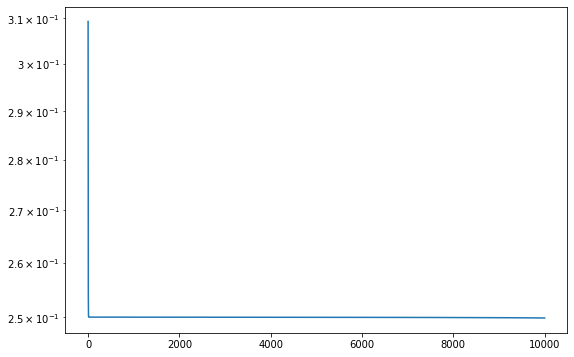

In [239]:
# Plot the error vs epochs
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

# My implementation

## Forwad feed once

In [33]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# Error
print('Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.49003932, 0.48817104, 0.50629395, ..., 0.486346  , 0.5068818 ,
        0.51280135],
       [0.5100677 , 0.50139165, 0.49643084, ..., 0.49373865, 0.49735844,
        0.50800294],
       [0.50010705, 0.48956198, 0.502725  , ..., 0.48009145, 0.5042405 ,
        0.52079576]], dtype=float32), array([[0.46120936, 0.36138815, 0.30492193, ..., 0.62413985, 0.59955317,
        0.4224788 ],
       [0.4615413 , 0.35907194, 0.30458722, ..., 0.62566704, 0.59944385,
        0.4230656 ],
       [0.46419272, 0.36222392, 0.3051756 , ..., 0.6265128 , 0.60206956,
        0.42540574],
       [0.46452528, 0.35990503, 0.3048399 , ..., 0.6280362 , 0.6019605 ,
        0.42599288]], dtype=float32), array([[0.2660938 , 0.47074488, 0.41315237, ..., 0.36766136, 0.35755593,
      

## Backpropagation

In [34]:
# Get the derivative of the output cost function wrt to the output vector of the output layer
# The input arguments should always be an array
dc_daL = MSE_loss_grad(a[nLayers], outputs)/batchSize
print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)

# Perform Back Propagation and get the derivatives wrt the weights and biases
derWeights, derBiases, weights, biases = back_propagation(z, a, activation_func_names, nLayers, batchSize, weightsOriginal, biasesOriginal, eeta, dc_daL)
print('Gradient of Cost (error function) wrt weights:\n',derWeights)
print('Gradient of Cost (error function) wrt biases:\n',derBiases)

Gradient of the error function wrt to the predicted output of the output layer
 [[ 0.20877738]
 [-0.29126984]
 [-0.29110923]
 [ 0.20884338]]
Gradient of Cost (error function) wrt weights:
 [array([[-6.7160981e-06, -6.7713172e-06],
       [-1.9493937e-06, -1.9685804e-06],
       [-1.2742665e-05, -1.2726250e-05],
       ...,
       [-7.6289439e-07, -7.9831716e-07],
       [-4.5078459e-06, -4.4236522e-06],
       [-2.6377788e-06, -2.7000710e-06]], dtype=float32), array([[ 2.26507400e-05,  2.24121595e-05,  2.27100572e-05, ...,
         2.21972368e-05,  2.27443470e-05,  2.31197191e-05],
       [-3.42741941e-06, -3.39126609e-06, -3.43558486e-06, ...,
        -3.35870482e-06, -3.44076398e-06, -3.49749234e-06],
       [-3.15673096e-05, -3.12345001e-05, -3.16483347e-05, ...,
        -3.09347161e-05, -3.16961414e-05, -3.22194428e-05],
       ...,
       [-1.26286341e-05, -1.24941944e-05, -1.26599225e-05, ...,
        -1.23731097e-05, -1.26792038e-05, -1.28903139e-05],
       [-3.85124258e-05, -3

## Gradient descent (update the weights and biases)

In [35]:
newWeights = [weightsOriginal[i] - eeta*derWeights[i] for i in range(nLayers)]
print('New Weights: ', newWeights)

newBiases = [biasesOriginal[i] - eeta*derBiases[i] for i in range(nLayers)]
# newBiases = biasesOriginal
print('New Biases: ', newBiases)

New Weights:  [array([[ 0.04027955, -0.03984465],
       [ 0.00556753, -0.04732367],
       [-0.01427054,  0.02518347],
       ...,
       [-0.0250464 , -0.05462918],
       [-0.01056414,  0.027531  ],
       [ 0.03201582,  0.05121794]], dtype=float32), array([[ 0.03018852, -0.00487641,  0.00298921, ..., -0.00576888,
         0.00109794, -0.02996279],
       [-0.02509252, -0.00930041,  0.03436106, ...,  0.00702566,
        -0.0210026 ,  0.03212038],
       [ 0.03598116, -0.03663293,  0.03604322, ..., -0.03208125,
        -0.03818724, -0.02089714],
       ...,
       [ 0.03194422, -0.03543187, -0.03110309, ..., -0.02737474,
        -0.02371899, -0.03059182],
       [ 0.02860489,  0.03229774,  0.0281264 , ...,  0.03349115,
        -0.01706082, -0.01940624],
       [-0.02177706,  0.03210373, -0.00254965, ...,  0.00418863,
        -0.00810771,  0.02265545]], dtype=float32), array([[ 3.67073230e-02,  1.28417108e-02,  2.35879538e-03, ...,
        -7.05265207e-03, -3.29059549e-02,  2.70009618

## Forward feed again and check the loss/error

In [36]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# New Error
print('New Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , ..., 0.5       , 0.5       ,
        0.5       ],
       [0.49003932, 0.48817104, 0.50629395, ..., 0.486346  , 0.5068818 ,
        0.51280135],
       [0.5100677 , 0.50139165, 0.49643084, ..., 0.49373865, 0.49735844,
        0.50800294],
       [0.50010705, 0.48956198, 0.502725  , ..., 0.48009145, 0.5042405 ,
        0.52079576]], dtype=float32), array([[0.46120936, 0.36138815, 0.30492193, ..., 0.62413985, 0.59955317,
        0.4224788 ],
       [0.4615413 , 0.35907194, 0.30458722, ..., 0.62566704, 0.59944385,
        0.4230656 ],
       [0.46419272, 0.36222392, 0.3051756 , ..., 0.6265128 , 0.60206956,
        0.42540574],
       [0.46452528, 0.35990503, 0.3048399 , ..., 0.6280362 , 0.6019605 ,
        0.42599288]], dtype=float32), array([[0.2660938 , 0.47074488, 0.41315237, ..., 0.36766136, 0.35755593,
      

## ** With np.einsum (slightly Slower than opt_einsum expression reuse)**

In [240]:
%%time

# Run optimization
optWeights, optBiases, errorPlot = nn_optimize(inputs, outputs, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=MSE_loss, gradErrorFunc=MSE_loss_grad,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.3093292135745287
Wall time: 6.84 s


In [241]:
print(errorPlot)

[0.3093292135745287, 0.28964087925851345, 0.27428185008466244, 0.2638254538178444, 0.25747372582554817, 0.25391463190317154, 0.2520175352692604, 0.251034215092659, 0.25053204596042633, 0.2502775192260742, 0.2501489669084549, 0.25008414685726166, 0.25005150958895683, 0.2500350624322891, 0.25002677366137505, 0.25002259761095047, 0.25002049654722214, 0.2500194385647774, 0.2500188872218132, 0.2500186040997505, 0.2500184699892998, 0.2500183805823326, 0.2500183507800102, 0.25001833960413933, 0.25001829117536545, 0.25001829117536545, 0.25001827254891396, 0.25001826882362366, 0.25001827627420425, 0.25001825019717216, 0.25001824647188187, 0.25001825019717216, 0.2500182203948498, 0.2500182092189789, 0.2500182315707207, 0.2500182241201401, 0.2500182017683983, 0.2500181868672371, 0.2500181719660759, 0.2500181645154953, 0.2500181794166565, 0.2500181570649147, 0.2500181421637535, 0.2500181421637535, 0.2500181421637535, 0.2500181198120117, 0.25001809746026993, 0.25001808255910873, 0.25001809000968933

In [242]:
print(errorPlot)

[0.3093292135745287, 0.28964087925851345, 0.27428185008466244, 0.2638254538178444, 0.25747372582554817, 0.25391463190317154, 0.2520175352692604, 0.251034215092659, 0.25053204596042633, 0.2502775192260742, 0.2501489669084549, 0.25008414685726166, 0.25005150958895683, 0.2500350624322891, 0.25002677366137505, 0.25002259761095047, 0.25002049654722214, 0.2500194385647774, 0.2500188872218132, 0.2500186040997505, 0.2500184699892998, 0.2500183805823326, 0.2500183507800102, 0.25001833960413933, 0.25001829117536545, 0.25001829117536545, 0.25001827254891396, 0.25001826882362366, 0.25001827627420425, 0.25001825019717216, 0.25001824647188187, 0.25001825019717216, 0.2500182203948498, 0.2500182092189789, 0.2500182315707207, 0.2500182241201401, 0.2500182017683983, 0.2500181868672371, 0.2500181719660759, 0.2500181645154953, 0.2500181794166565, 0.2500181570649147, 0.2500181421637535, 0.2500181421637535, 0.2500181421637535, 0.2500181198120117, 0.25001809746026993, 0.25001808255910873, 0.25001809000968933

#### Test the quality of the weights by running a forward feed again

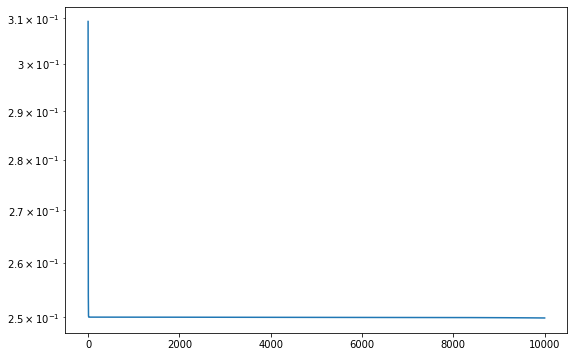

In [243]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [244]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', MSE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 0.57090807, -0.23015423],
       [ 0.30902758,  0.09052671],
       [ 0.43549138, -0.64729494],
       [-0.5925555 ,  0.58117914],
       [ 0.30062437,  0.33596167],
       [-0.6444482 , -0.19908367],
       [ 0.05296446, -0.45231858],
       [ 0.509657  ,  0.45519656],
       [ 0.6300169 ,  0.14263384],
       [-0.4873592 , -0.6583125 ]], dtype=float32), array([[ 0.00770684, -0.40511817,  0.13106419,  0.53858835, -0.5400419 ,
        -0.24690281,  0.42148882, -0.35330403,  0.06692535, -0.27320653],
       [ 0.0697288 ,  0.45413283, -0.50233513,  0.19075279, -0.00688506,
        -0.08994538,  0.5508172 ,  0.10751811, -0.27167383,  0.02836027],
       [-0.33444148,  0.19763057, -0.5201104 , -0.4127929 ,  0.37710592,
         0.40098423, -0.1210918 ,  0.20593333,  0.2623955 ,  0.1927005 ],
       [ 0.11035351,  0.1683874 ,  0.48066396, -0.2462959 ,  0.2875991 ,
         0.09055822, -0.45083734, -0.49522674,  0.03993616, -0.29736546],
       [-0.14195335, -0.

In [245]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
1.5199184e-06
6.2584877e-07

Layer :  2
8.34465e-07
9.9651515e-08

Layer :  3
1.2516975e-06
3.2177195e-07

Layer :  4
2.8014183e-06
1.4901161e-08


## ** NEW METHOD ** With opt_einsum expressions (It is faster than np.einsum but only slightly)

In [246]:
%%time
# Run optimization
optWeights, optBiases, errorPlot = nn_optimize_fast(inputs, outputs, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=MSE_loss, gradErrorFunc=MSE_loss_grad,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.3093292135745287
Wall time: 11.9 s


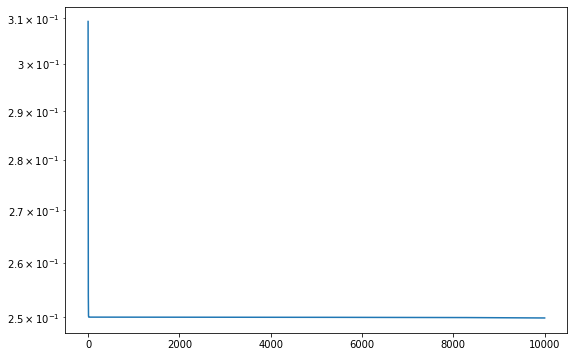

In [247]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [248]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', BCE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 0.5709079 , -0.23015407],
       [ 0.30902746,  0.0905265 ],
       [ 0.43549153, -0.64729506],
       [-0.5925549 ,  0.58117914],
       [ 0.30062443,  0.33596185],
       [-0.6444483 , -0.19908339],
       [ 0.05296439, -0.45231852],
       [ 0.5096574 ,  0.45519713],
       [ 0.630017  ,  0.14263366],
       [-0.48735875, -0.6583121 ]], dtype=float32), array([[ 0.00770688, -0.4051182 ,  0.13106422,  0.5385882 , -0.540042  ,
        -0.24690278,  0.4214887 , -0.35330418,  0.06692535, -0.27320638],
       [ 0.0697288 ,  0.4541329 , -0.50233525,  0.19075286, -0.00688511,
        -0.0899452 ,  0.55081725,  0.10751772, -0.27167386,  0.02836058],
       [-0.3344414 ,  0.19763044, -0.5201103 , -0.41279304,  0.37710607,
         0.40098417, -0.12109184,  0.20593329,  0.26239565,  0.19270067],
       [ 0.11035349,  0.16838738,  0.4806638 , -0.24629577,  0.28759903,
         0.09055829, -0.45083752, -0.49522698,  0.03993609, -0.29736543],
       [-0.1419533 , -0.

In [249]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
2.0861626e-06
9.536743e-07

Layer :  2
1.1324883e-06
2.02097e-07

Layer :  3
1.0728836e-06
2.8684735e-07

Layer :  4
3.33786e-06
3.7252903e-07


# PyTorch

In [250]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

## Generate the network programatically

## Method 1

In [251]:
Layers = []
# Input layer
Layers.append(torch.nn.Linear(nInputs, neurons_per_layer[0]))
Layers.append(torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Layers.append(torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Layers.append(torch.nn.Sigmoid())
    # Output layer
    Layers.append(torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Layers.append(torch.nn.Sigmoid())

In [252]:
Network = torch.nn.Sequential(*Layers)

In [253]:
print(Network)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=10, out_features=1, bias=True)
  (7): Sigmoid()
)


## Method 2 (Suitable for us to modify weights for each layer to be same as keras and my implementation)

In [254]:
Network = torch.nn.Sequential()
 
# Input layer -> 1st hidden layer
Network.add_module(str(0),torch.nn.Linear(nInputs, neurons_per_layer[0]))
# Activation function after first hidden layer
Network.add_module('act0',act_func_dict_PyTorch[activation_func_names[0]])

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Network.add_module(str(i),torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Network.add_module('act'+str(i),act_func_dict_PyTorch[activation_func_names[i]])
        
    # Output layer
    Network.add_module(str(nLayers-1),torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Network.add_module('act'+str(nLayers-1),act_func_dict_PyTorch[activation_func_names[nLayers-1]])

In [255]:
# torch.nn.init.constant_(Network.weight, 2.0)
Network.to(device=device)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=10, out_features=10, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (act2): Sigmoid()
  (3): Linear(in_features=10, out_features=1, bias=True)
  (act3): Sigmoid()
)

## initial weights and biases generated by Pytorch

In [256]:
print(Network[0].weight)
print(Network[0].bias)

Parameter containing:
tensor([[-0.2700, -0.0863],
        [ 0.2852,  0.0420],
        [ 0.5233, -0.1002],
        [-0.0073, -0.1342],
        [-0.1949,  0.6292],
        [ 0.2781, -0.0436],
        [ 0.5210,  0.1102],
        [-0.0855, -0.2952],
        [-0.5218,  0.6541],
        [ 0.3811, -0.0295]], requires_grad=True)
Parameter containing:
tensor([-0.4238, -0.5650,  0.6571, -0.3082,  0.6400, -0.2085,  0.3744, -0.6511,
        -0.4595, -0.4412], requires_grad=True)


## Change them to be the same as others

## **IMPORTANT NOTE**: The returned tensor and the original array share the same memory. So any changes to the tensor change the array as well.

Reference: https://pytorch.org/docs/stable/generated/torch.from_numpy.html



In [257]:
for i in range(nLayers):
    # Weights
#     Network._modules[str(i)].weight.data = torch.from_numpy(weightsOriginal[i]).to(dtype=torch.float32)
    Network._modules[str(i)].weight.data = torch.tensor(weightsOriginal[i]).to(dtype=torch.float32)
    # Biases
#     Network._modules[str(i)].bias.data = torch.from_numpy(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32
    Network._modules[str(i)].bias.data = torch.tensor(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32

In [258]:
for i in range(nLayers):
    # Weights
    print('Weights:\n')
    print(Network._modules[str(i)].weight.data)
    # Biases
    print('Biases:\n')
    print(Network._modules[str(i)].bias.data)

Weights:

tensor([[ 0.6659, -0.2963],
        [ 0.3256,  0.1448],
        [ 0.4218, -0.5514],
        [-0.5749,  0.6142],
        [ 0.2814,  0.2341],
        [-0.6080, -0.1410],
        [ 0.0729, -0.3917],
        [ 0.4147,  0.2884],
        [ 0.6484,  0.1806],
        [-0.3169, -0.4997]])
Biases:

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Weights:

tensor([[ 0.0099, -0.4033,  0.1349,  0.5367, -0.5383, -0.2485,  0.4233, -0.3504,
          0.0705, -0.2744],
        [ 0.0554,  0.4525, -0.5050,  0.2039, -0.0038, -0.0922,  0.5457,  0.1176,
         -0.2708,  0.0096],
        [-0.3600,  0.2078, -0.4795, -0.3917,  0.4054,  0.3632, -0.1231,  0.2809,
          0.3021,  0.0923],
        [ 0.0952,  0.1681,  0.5044, -0.2435,  0.2945,  0.0737, -0.4491, -0.4665,
          0.0530, -0.3420],
        [-0.1468, -0.5109, -0.2562, -0.3068, -0.5049, -0.2613,  0.3378,  0.0725,
          0.2654, -0.5217],
        [ 0.4017,  0.4948,  0.1142, -0.1233, -0.3952,  0.0609, -0.4570, -0.4763,
          0.042

In [259]:
### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
# crit = torch.nn.BCELoss()
# opt = torch.optim.SGD(Network.parameters(), lr=0.2)

crit = torch.nn.MSELoss()
opt = torch.optim.SGD(Network.parameters(), lr=eeta)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=10, out_features=10, bias=True)
  (act1): Sigmoid()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (act2): Sigmoid()
  (3): Linear(in_features=10, out_features=1, bias=True)
  (act3): Sigmoid()
)
261 trainable parameters


In [260]:
inputsTorch = torch.from_numpy(inputs)
inputsTorch = inputsTorch.to(dtype=torch.float32) # Convert to float32
labels = torch.from_numpy(outputs)
labels = labels.to(dtype=torch.float32) # Convert to float32

In [261]:
print(inputsTorch)
print(labels)

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])
tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [262]:
%%time
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, nEpochs)
errorPlot = []
### Train the model
for e in tqdm(epochs,leave=True,miniters=100):
    tr_loss = 0.
    samples = 0
    
    opt.zero_grad() # zero gradient values
    inputsTorch = inputsTorch.to(device=device) # move input and label tensors to the device with the model
    labels = labels.to(device=device)
    outputsTorch = Network(inputsTorch) # compute model outputs
    loss = crit(outputsTorch, labels) # compute batch loss
    loss.backward() # back-propagate the gradients
    opt.step() # update the model weights
    tr_loss += loss.clone().cpu().item()*len(inputsTorch) # add the batch loss to the running loss
    samples += len(inputsTorch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
#     print(e, tr_loss)

  0%|          | 0/9999 [00:00<?, ?it/s]

Wall time: 3.26 s


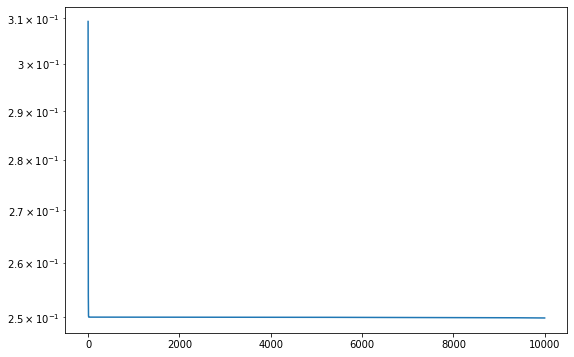

In [263]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [264]:
print('Difference b/w our weights & biases and PyTorch results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(torch.tensor(optWeights[i]).to(dtype=torch.float32)-Network._modules[str(i)].weight.data).max())
    print(abs(torch.tensor(optBiases[i]).to(dtype=torch.float32)-Network._modules[str(i)].bias.data).max())

Difference b/w our weights & biases and PyTorch results:

Layer :  1
tensor(6.8277e-05)
tensor(3.5331e-05)

Layer :  2
tensor(5.9426e-05)
tensor(1.7565e-06)

Layer :  3
tensor(4.5955e-05)
tensor(1.1433e-05)

Layer :  4
tensor(3.6478e-05)
tensor(3.6508e-06)


In [265]:
torch.get_num_threads()

8

In [60]:
# torch.set_num_threads(4)
torch.get_num_threads()

8

In [61]:
torch.get_num_threads()

8